In [133]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2lab, rgb2hsv, hsv2rgb
from skimage import img_as_ubyte
from PIL import Image

import sys
sys.path.insert(0, "/home/luke/luke-gripper-ros/rl/gripper_dqn/scripts")
from grasp_test_data import GraspTestData, set_palm_frc_threshold

from ModelSaver import ModelSaver

In [112]:
simruns = ["run_16-54_A41", "run_16-54_A51", "run_16-54_A61", "run_16-54_A71"]

simloader = ModelSaver(f"models/sim_images/{simruns[0]}")
simdata = simloader.load("image_collection", id=0)
print(f"The number of datapoints is {len(simdata)}")

Loading file models/sim_images/run_16-54_A41/image_collection_008.lz4 with pickle ... 

finished
The number of datapoints is 1000


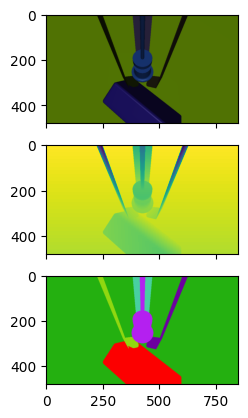

In [113]:
def visualise_sim_image(datapoint, rgb=True, depth=False, seg=False):
  """
  Show a simulated image
  """

  num = rgb + depth + seg

  fig, axs = plt.subplots(num, 1, sharex=True)
  k = 0

  if num == 1: axs = [axs]

  # numpy likes image arrays like this: height x width x channels (ie rows x columns x dim)
  # torch likes image arrays like this: channels x width x height
  # hence convert from torch style back to numpy style for plotting

  if rgb:
    axs[k].imshow(np.einsum("ijk->kji", datapoint["rgb"])) # swap to numpy style rows/cols (eg 3x640x480 -> 480x640x3)
    k += 1

  if depth:
    axs[k].imshow(np.transpose(datapoint["depth"])) # remove the depth 'channel' then swap (eg 1x640x480 -> 480x640)
    k += 1

  if seg:
    max_num = np.max(datapoint["rgb_mask"])
    scale = 255 // max_num

    # apply scalings to give each mask integers (1-7 usually) a different colour
    red_scaled = scale * (datapoint["rgb_mask"])
    green_scaled = scale * 2 * (max_num - datapoint["rgb_mask"]) * (datapoint["rgb_mask"] % 3)
    blue_scaled = scale * 2 * (max_num - datapoint["rgb_mask"]) * (datapoint["rgb_mask"] + 2 % 3)

    # reconstruct a three-channel image
    scaled_rgb = np.array([red_scaled, green_scaled, blue_scaled], dtype=np.uint8)

    # plot the visualisation of the mask
    axs[k].imshow(np.einsum("ijk->kji", scaled_rgb)) # swap to numpy style rows/cols (eg 3x640x480 -> 480x640x3)
    k += 1

  plt.show()

visualise_sim_image(simdata[13], rgb=True, depth=True, seg=True)

In [114]:
real_tests = ["pb1_E1_S0", "pb1_E1_S2", "pb1_E2_S3", "pb1_E2_S3_YCB", "real_heuristic", "pb1_E1_S1", 
              "pb1_E1_S3", "pb1_E2_S3_real", "pb1_E3_S3", "YCB_heuristic"]

realloader = ModelSaver(f"models/pb1_test_data/{real_tests[2]}")
num_files = realloader.get_recent_file(name="trial_image_batch", return_int=True)
print(f"The number of image files is {num_files}")
realdata = realloader.load("trial_image_batch", id=3)
realimages = realdata.trials[0].images
print(f"The number of images is {len(realimages)}")

data_explorer = GraspTestData()


Biggest number found was 150
Number of matching files found 150
The number of image files is 150
Loading file models/pb1_test_data/pb1_E2_S3/trial_image_batch_003.lz4 with pickle ... finished
The number of images is 44


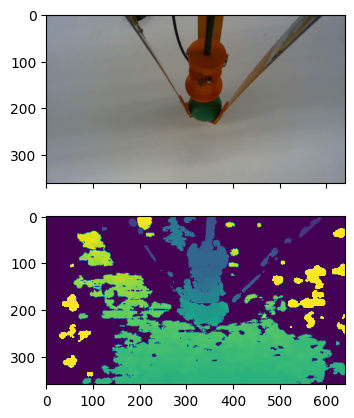

In [115]:
def visualise_real_image(realimage, rgb=True, depth=False):
  """
  Show a simulated image
  """

  num = rgb + depth

  fig, axs = plt.subplots(num, 1, sharex=True)
  k = 0

  if num == 1: axs = [axs]

  # numpy likes image arrays like this: height x width x channels (ie rows x columns x dim)
  # torch likes image arrays like this: channels x width x height
  # hence convert from torch style back to numpy style for plotting

  if rgb:
    axs[k].imshow(realimage.rgb) # swap to numpy style rows/cols (eg 3x640x480 -> 480x640x3)
    k += 1

  if depth:
    # saturate any values above this (ignore outliers)
    depth_max = 5000

    # find minimum of minima & maximum of depth data
    dmin = 1e10
    dmax = -1e10
    this_min = np.min(realimage.depth[realimage.depth < depth_max])
    this_max = np.max(realimage.depth[realimage.depth < depth_max])
    if this_min < dmin: dmin = this_min
    if this_max > dmax: dmax = this_max
    axs[k].imshow(realimage.depth, vmin=dmin, vmax=dmax, cmap="viridis")
    k += 1


  plt.show()

visualise_real_image(realimages[32], rgb=True, depth=True)

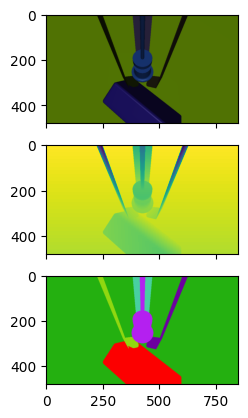

(3, 848, 480)
(1, 848, 480)
(1, 848, 480)
(5, 848, 480)


In [116]:
def resize_and_save_sim_image(datapoint, saveas="test_img.jpg", width=100, height=100):
  """
  Change the size of a simulated image
  """
  
  print(datapoint["rgb"].shape)
  print(datapoint["depth"].shape)
  print(np.expand_dims(datapoint["rgb_mask"], axis=0).shape)

  new_img_array = np.concatenate((datapoint["rgb"], 
                                  datapoint["depth"], 
                                  np.expand_dims(datapoint["rgb_mask"], axis=0)), 
                                  axis=0, dtype=np.float64)
  
  print(new_img_array.shape)

  img_resized = resize(new_img_array, (5, width, height))

  # Convert the NumPy array to a PIL Image
  image = Image.fromarray(np.einsum("ijk->kji", img_resized[:3]).astype(np.uint8))

  # Save the image as a JPEG file
  image.save("test_img.jpg", 'JPEG')

visualise_sim_image(simdata[13], rgb=True, depth=True, seg=True)
new_array = resize_and_save_sim_image(simdata[12], saveas="test_img.jpg", width=80, height=45)
# visualise_sim_image(simdata[13], rgb=True, depth=True, seg=True)

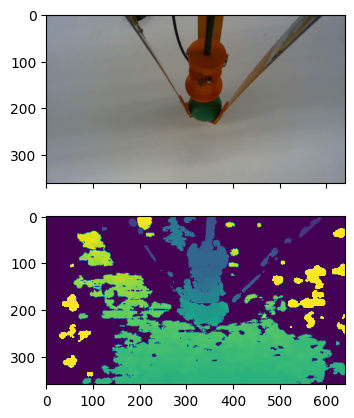

(360, 640, 3)
(360, 640, 1)
(4, 640, 360)


In [117]:
def resize_and_save_real_image(realimage, saveas="test_img.jpg", width=100, height=100):
  """
  Change the size of a real image
  """

  print(realimage.rgb.shape)
  print(np.expand_dims(realimage.depth, axis=2).shape)

  new_img_array = np.concatenate((realimage.rgb, 
                                  np.expand_dims(realimage.depth, axis=2)), 
                                  axis=2, dtype=np.float64)
  new_img_array = np.einsum("ijk->kji", new_img_array)
  
  print(new_img_array.shape)

  img_resized = resize(new_img_array, (4, width, height))

  # Convert the NumPy array to a PIL Image
  image = Image.fromarray(np.einsum("ijk->kji", img_resized[:3]).astype(np.uint8))
  # image = Image.fromarray(img_resized[:,:,:3].astype(np.uint8))

  # Save the image as a JPEG file
  image.save("test_img.jpg", 'JPEG')

visualise_real_image(realimages[32], rgb=True, depth=True)
resize_and_save_real_image(realimages[32], width=80, height=45)
  

(360, 640, 3)
[[[60.6946566  -1.51394155  3.04695523]
  [60.6946566  -1.51394155  3.04695523]
  [61.07693564 -1.51217474  3.04316487]
  [61.07693564 -1.51217474  3.04316487]
  [61.15819984 -1.1419853   3.17101068]
  [60.77602189 -1.14325614  3.17495641]
  [61.15819984 -1.1419853   3.17101068]
  [61.15819984 -1.1419853   3.17101068]
  [60.77602189 -1.14325614  3.17495641]
  [61.15819984 -1.1419853   3.17101068]]

 [[60.6946566  -1.51394155  3.04695523]
  [60.6946566  -1.51394155  3.04695523]
  [61.07693564 -1.51217474  3.04316487]
  [61.07693564 -1.51217474  3.04316487]
  [61.15819984 -1.1419853   3.17101068]
  [61.15819984 -1.1419853   3.17101068]
  [61.92114212 -1.13946879  3.16320715]
  [61.92114212 -1.13946879  3.16320715]
  [60.77602189 -1.14325614  3.17495641]
  [61.15819984 -1.1419853   3.17101068]]

 [[61.07693564 -1.51217474  3.04316487]
  [61.07693564 -1.51217474  3.04316487]
  [61.07693564 -1.51217474  3.04316487]
  [61.84007788 -1.50867804  3.03566874]
  [61.92114212 -1.1394

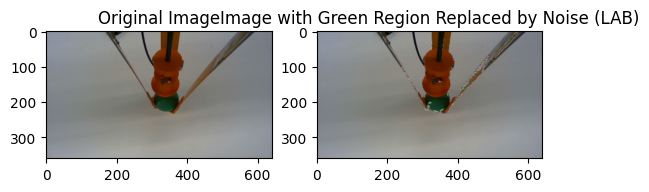

In [124]:
def replace_green_region_with_noise_lab(image):

    # Convert the image to LAB color space
    lab_image = rgb2lab(image)

    print(lab_image[300:310, 200:210, :])

    # Define the lower and upper bounds for green color in LAB
    lower_green = np.array([20, -40, 10])  # Adjust as needed
    upper_green = np.array([60, 20, 20])    # Adjust as needed

    # Create a mask for the green region
    green_mask = np.all((lab_image >= lower_green) & (lab_image <= upper_green), axis=-1)

    # Generate uniform noise of the same size as the image
    noise = np.random.randint(0, 256, size=image.shape, dtype=np.uint8)

    # Replace the green region with uniform noise
    image_with_noise = np.where(green_mask[:, :, np.newaxis], noise, image)

    return image_with_noise

# your_image_array = np.einsum("ijk->kji", realimages[20].rgb)
your_image_array = realimages[32].rgb

print(your_image_array.shape)

# Replace the green region with uniform noise using LAB color space
output_image_array = replace_green_region_with_noise_lab(your_image_array)

# Display the original and modified images (if needed)
plt.subplot(1, 2, 1)
plt.imshow(your_image_array)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(output_image_array)
plt.title('Image with Green Region Replaced by Noise (LAB)')

plt.show()

(360, 640, 3)


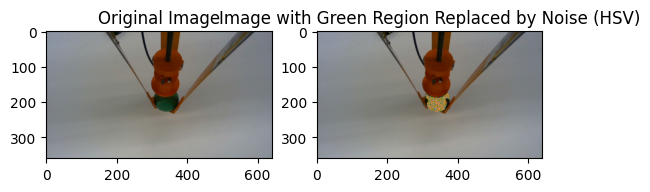

In [166]:
def replace_green_region_with_noise_hsv(image):

    # # Transpose the image to have shape (height x width x channel)
    # image = np.transpose(image, (1, 2, 0))

    # Convert the image to HSV color space
    hsv_image = rgb2hsv(image)

    # print(hsv_image[300:310, 200:210, :])

    # Define the lower and upper bounds for green color in HSV
    lower_green = np.array([60 / 360, 0.2, 0.1])  # Adjust as needed
    upper_green = np.array([180 / 360, 0.9, 0.7])  # Adjust as needed

    # Create a mask for the green region
    green_mask = np.all((hsv_image >= lower_green) & (hsv_image <= upper_green), axis=-1)

    # Generate uniform noise of the same size as the image
    noise_value = 30
    noise = np.random.randint(-noise_value, noise_value, size=image.shape, dtype=np.int8)
    block_colour = np.random.randint(0, 256, size=(1, 1, 3), dtype=np.uint8)
    block_colour[:, :, 0] = np.random.randint(0, 256)
    block_colour[:, :, 1] = np.random.randint(0, 256)
    block_colour[:, :, 2] = np.random.randint(0, 256)
    noise = np.array(noise + block_colour, dtype=np.uint8)

    # Replace the green region with uniform noise
    image_with_noise = np.where(green_mask[:, :, np.newaxis], noise, image)

    # # Transpose the image back to the original format (channel x width x height)
    # image_with_noise = np.transpose(image_with_noise, (2, 0, 1))

    return image_with_noise

# your_image_array = np.einsum("ijk->kji", realimages[20].rgb)
your_image_array = realimages[32].rgb

print(your_image_array.shape)

# Replace the green region with uniform noise using LAB color space
output_image_array = replace_green_region_with_noise_hsv(your_image_array)
# output_image_array = replace_green_region_with_noise_lab(output_image_array)

# Display the original and modified images (if needed)
plt.subplot(1, 2, 1)
plt.imshow(your_image_array)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(output_image_array)
plt.title('Image with Green Region Replaced by Noise (HSV)')

plt.show()